In [1]:
import sys, os, gc
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import random
from datetime import datetime
import json
import imgaug as ia
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

In [2]:
def vgg6(input_shape=(128, 128, 3)):


    model = tf.keras.models.Sequential(name='VGG6')

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    ## Fully connected layers
    model.add(tf.keras.layers.Flatten())

       
    model.add(tf.keras.layers.Dense(128, activation='relu', name='fc_3'))
    
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_4'))

    model.add(tf.keras.layers.Dense(8, activation='relu', name='fc_5'))
    # output layer
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

def esn_shuffle(array, seed=0):
        np.random.seed(seed)
        np.random.shuffle(array)
        return array

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


In [3]:
model = vgg6()
model.summary()

Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 126, 126, 32)      896       
_________________________________________________________________
conv2 (Conv2D)               (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 60, 60, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 58, 58, 64)        36928     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 58, 58, 64)        256    

In [4]:
def esn_shuffle(array, seed=None):
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(array)
        return array

In [5]:
seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),
    iaa.Add((-5, 5), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


seqGray = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

In [6]:
%%time 

data = np.load('samples_binary/RGB_128x128_test_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples_binary/g_128x128_test_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples_binary/r_128x128_test_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples_binary/i_128x128_test_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

CPU times: user 2.85 s, sys: 188 ms, total: 3.04 s
Wall time: 3.04 s


In [7]:
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

N_RGB = len(labels_RGB)
N_gri = len(labels_gri)

In [8]:
ia.seed(100)

indx = esn_shuffle(np.arange(N_gri), seed=200)
images_aug = seqGray(images=images_gri[indx][:N_RGB,:,:,:])
labels_aug = labels_gri[indx][:N_RGB]
pgcIDs_aug = pgcIDs_gri[indx][:N_RGB]
filter_aug = filter_gri[indx][:N_RGB]

n = len(images_aug)
p = int(n/2)
images_aug[:p] = 255 - images_aug[:p]

ia.seed(200)

images_aug = np.concatenate((seq(images=images_RGB),images_aug))
labels_aug = np.concatenate((labels_RGB,labels_aug))
pgcIDs_aug = np.concatenate((pgcIDs_RGB,pgcIDs_aug))
filter_aug = np.concatenate((filter_RGB,filter_aug))

indx = np.arange(len(images_aug))
indx = esn_shuffle(indx, seed=100)
images_test_aug = images_aug[indx]
labels_test_aug = labels_aug[indx]
pgcIDs_test_aug = pgcIDs_aug[indx]
filter_test_aug = filter_aug[indx]



In [9]:
len(labels_test_aug[(labels_test_aug==1)])

1201

(array([3369.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1201.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

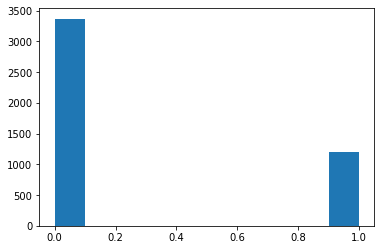

In [10]:
plt.hist(labels_test_aug)

In [11]:
batches = esn_shuffle(np.arange(50), seed=20)

for i in range(1,60):
    batches = np.concatenate((batches, esn_shuffle(np.arange(50), seed=i*20))) 

batches, len(batches)

(array([12, 14,  4, ..., 14, 15, 45]), 3000)

In [12]:
zp_dir = 'Uset0_binary_npz/'
ckpt_dir = 'U0_model06_binary_ckpt/'

def trainer(iter, batches, suffix=None):

  if suffix is None:
    suffix = ''

  batchNo = batches[iter]
  if True: 

    vgg_model = vgg6()
    vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if iter>0:

      vgg_model = vgg6()
      vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      vgg_model.load_weights(ckpt_dir+str(iter-1)+suffix+".ckpt")

      # if batchNo % 2 == 0 : 
      #   for layer in vgg_model.layers[:-1]:
      #     layer.trainable = False

      with open(ckpt_dir+'evalDict'+suffix+'.json') as json_file:
        evalDict = json.load(json_file)
    else:
      evalDict = {}


    print(iter, batchNo)


    batchFile = npzname = '128x128_train_aug_'+'%02d'%(batchNo+1)+'.npz'
    data = np.load(zp_dir + batchFile)
    images_train_aug = data['images'].astype(np.uint8)
    labels_train_aug = data['labels']
    pgcIDs_train_aug = data['pgcIDs']
    data.close() 
    del data

    
    n_epochs=1
    vgg_model.fit(images_train_aug, labels_train_aug, 
                                      epochs=n_epochs, batch_size=64, 
                                      validation_data=(images_test_aug, labels_test_aug),
                                      verbose=1, shuffle=True)
    evalDict[iter] = {} 
    for key in vgg_model.history.history:
      evalDict[iter][key] = vgg_model.history.history[key][0]
    evalDict[iter]["batchNo"] = batchNo
    evalDict[iter]["batchFile"] = batchFile
    
    with open(ckpt_dir+"evalDict"+suffix+".json", "w", encoding ='utf8') as outfile:
      json.dump(evalDict, outfile, allow_nan=True, cls=NpEncoder)
    
    vgg_model.save_weights(ckpt_dir+str(iter)+suffix+".ckpt")

    del vgg_model
    tf.keras.backend.clear_session()
    del images_train_aug 
    del labels_train_aug
    del pgcIDs_train_aug

    gc.collect()

    return evalDict

In [ ]:
with tf.device('/gpu:1'):
    for i in range(0,2000):
        trainer(i, batches)

0 12
313/313 [==============================] - 17s 56ms/step - loss: 0.6881 - accuracy: 0.5394 - val_loss: 0.6274 - val_accuracy: 0.5495
1 14
313/313 [==============================] - 13s 41ms/step - loss: 0.6460 - accuracy: 0.6096 - val_loss: 0.6619 - val_accuracy: 0.5199
2 4
313/313 [==============================] - 13s 40ms/step - loss: 0.6322 - accuracy: 0.6233 - val_loss: 0.6543 - val_accuracy: 0.5551
3 8
313/313 [==============================] - 13s 40ms/step - loss: 0.6055 - accuracy: 0.6505 - val_loss: 0.7665 - val_accuracy: 0.4958
4 45
313/313 [==============================] - 13s 40ms/step - loss: 0.5805 - accuracy: 0.6730 - val_loss: 0.7487 - val_accuracy: 0.4864
5 1
313/313 [==============================] - 12s 40ms/step - loss: 0.5653 - accuracy: 0.6838 - val_loss: 0.6858 - val_accuracy: 0.5219
6 25
313/313 [==============================] - 13s 40ms/step - loss: 0.5524 - accuracy: 0.6892 - val_loss: 0.6729 - val_accuracy: 0.5383
7 24
313/313 [=======================

313/313 [==============================] - 12s 40ms/step - loss: 0.3307 - accuracy: 0.8590 - val_loss: 0.3302 - val_accuracy: 0.8591
60 40
313/313 [==============================] - 12s 40ms/step - loss: 0.3323 - accuracy: 0.8573 - val_loss: 0.3715 - val_accuracy: 0.8422
61 17
313/313 [==============================] - 12s 39ms/step - loss: 0.3225 - accuracy: 0.8645 - val_loss: 0.3131 - val_accuracy: 0.8667
62 18
313/313 [==============================] - 12s 39ms/step - loss: 0.3253 - accuracy: 0.8619 - val_loss: 0.3220 - val_accuracy: 0.8637
63 0
313/313 [==============================] - 12s 40ms/step - loss: 0.3107 - accuracy: 0.8672 - val_loss: 0.3601 - val_accuracy: 0.8446
64 27
313/313 [==============================] - 13s 40ms/step - loss: 0.3178 - accuracy: 0.8646 - val_loss: 0.3393 - val_accuracy: 0.8508
65 33
313/313 [==============================] - 12s 39ms/step - loss: 0.3178 - accuracy: 0.8645 - val_loss: 0.3108 - val_accuracy: 0.8635
66 36
313/313 [===================

118 5
313/313 [==============================] - 12s 40ms/step - loss: 0.2902 - accuracy: 0.8781 - val_loss: 0.3217 - val_accuracy: 0.8648
119 13
313/313 [==============================] - 12s 39ms/step - loss: 0.2911 - accuracy: 0.8775 - val_loss: 0.2862 - val_accuracy: 0.8766
120 39
313/313 [==============================] - 12s 39ms/step - loss: 0.2861 - accuracy: 0.8788 - val_loss: 0.3115 - val_accuracy: 0.8696
121 17
313/313 [==============================] - 12s 40ms/step - loss: 0.2922 - accuracy: 0.8784 - val_loss: 0.2991 - val_accuracy: 0.8744
122 43
313/313 [==============================] - 12s 39ms/step - loss: 0.2878 - accuracy: 0.8767 - val_loss: 0.3223 - val_accuracy: 0.8683
123 24
313/313 [==============================] - 12s 40ms/step - loss: 0.2967 - accuracy: 0.8758 - val_loss: 0.3458 - val_accuracy: 0.8523
124 3
313/313 [==============================] - 12s 39ms/step - loss: 0.2923 - accuracy: 0.8773 - val_loss: 0.2858 - val_accuracy: 0.8779
125 22
313/313 [======

313/313 [==============================] - 12s 40ms/step - loss: 0.2689 - accuracy: 0.8880 - val_loss: 0.3216 - val_accuracy: 0.8665
177 25
313/313 [==============================] - 12s 40ms/step - loss: 0.2845 - accuracy: 0.8806 - val_loss: 0.2946 - val_accuracy: 0.8748
178 45
313/313 [==============================] - 12s 40ms/step - loss: 0.2776 - accuracy: 0.8835 - val_loss: 0.2918 - val_accuracy: 0.8722
179 47
313/313 [==============================] - 12s 39ms/step - loss: 0.2702 - accuracy: 0.8907 - val_loss: 0.3046 - val_accuracy: 0.8707
180 49
313/313 [==============================] - 12s 40ms/step - loss: 0.2765 - accuracy: 0.8823 - val_loss: 0.2794 - val_accuracy: 0.8842
181 44
313/313 [==============================] - 12s 39ms/step - loss: 0.2744 - accuracy: 0.8868 - val_loss: 0.2904 - val_accuracy: 0.8735
182 22
313/313 [==============================] - 12s 39ms/step - loss: 0.2681 - accuracy: 0.8905 - val_loss: 0.2834 - val_accuracy: 0.8842
183 36
313/313 [===========

313/313 [==============================] - 12s 40ms/step - loss: 0.2679 - accuracy: 0.8880 - val_loss: 0.2755 - val_accuracy: 0.8849
235 37
313/313 [==============================] - 12s 39ms/step - loss: 0.2546 - accuracy: 0.8930 - val_loss: 0.2998 - val_accuracy: 0.8678
236 4
313/313 [==============================] - 12s 40ms/step - loss: 0.2588 - accuracy: 0.8901 - val_loss: 0.2959 - val_accuracy: 0.8786
237 28
313/313 [==============================] - 12s 39ms/step - loss: 0.2617 - accuracy: 0.8918 - val_loss: 0.3177 - val_accuracy: 0.8593
238 9
313/313 [==============================] - 12s 39ms/step - loss: 0.2602 - accuracy: 0.8904 - val_loss: 0.3129 - val_accuracy: 0.8689
239 0
313/313 [==============================] - 12s 39ms/step - loss: 0.2590 - accuracy: 0.8914 - val_loss: 0.2950 - val_accuracy: 0.8698
240 5
313/313 [==============================] - 12s 39ms/step - loss: 0.2583 - accuracy: 0.8927 - val_loss: 0.3355 - val_accuracy: 0.8716
241 17
313/313 [===============

293 10
313/313 [==============================] - 12s 39ms/step - loss: 0.2463 - accuracy: 0.9001 - val_loss: 0.2602 - val_accuracy: 0.8891
294 15
313/313 [==============================] - 12s 39ms/step - loss: 0.2441 - accuracy: 0.9000 - val_loss: 0.3037 - val_accuracy: 0.8755
295 23
313/313 [==============================] - 12s 40ms/step - loss: 0.2527 - accuracy: 0.8924 - val_loss: 0.2895 - val_accuracy: 0.8757
296 39
313/313 [==============================] - 13s 40ms/step - loss: 0.2436 - accuracy: 0.8995 - val_loss: 0.2791 - val_accuracy: 0.8836
297 3
313/313 [==============================] - 12s 39ms/step - loss: 0.2495 - accuracy: 0.8947 - val_loss: 0.2876 - val_accuracy: 0.8783
298 24
313/313 [==============================] - 12s 39ms/step - loss: 0.2511 - accuracy: 0.8976 - val_loss: 0.2936 - val_accuracy: 0.8746
299 8
313/313 [==============================] - 12s 40ms/step - loss: 0.2472 - accuracy: 0.8967 - val_loss: 0.2842 - val_accuracy: 0.8814
300 9
313/313 [=======

313/313 [==============================] - 12s 39ms/step - loss: 0.2233 - accuracy: 0.9075 - val_loss: 0.2863 - val_accuracy: 0.8777
352 6
313/313 [==============================] - 12s 40ms/step - loss: 0.2221 - accuracy: 0.9067 - val_loss: 0.3086 - val_accuracy: 0.8753
353 24
313/313 [==============================] - 12s 40ms/step - loss: 0.2231 - accuracy: 0.9076 - val_loss: 0.3192 - val_accuracy: 0.8676
354 33
313/313 [==============================] - 12s 40ms/step - loss: 0.2201 - accuracy: 0.9095 - val_loss: 0.3447 - val_accuracy: 0.8705
355 41
313/313 [==============================] - 12s 39ms/step - loss: 0.2223 - accuracy: 0.9082 - val_loss: 0.3466 - val_accuracy: 0.8606
356 14
313/313 [==============================] - 12s 39ms/step - loss: 0.2301 - accuracy: 0.9054 - val_loss: 0.2900 - val_accuracy: 0.8790
357 30
313/313 [==============================] - 12s 40ms/step - loss: 0.2239 - accuracy: 0.9056 - val_loss: 0.2859 - val_accuracy: 0.8834
358 48
313/313 [============

313/313 [==============================] - 12s 40ms/step - loss: 0.2092 - accuracy: 0.9143 - val_loss: 0.3030 - val_accuracy: 0.8796
410 46
313/313 [==============================] - 12s 39ms/step - loss: 0.2175 - accuracy: 0.9110 - val_loss: 0.2798 - val_accuracy: 0.8871
411 33
313/313 [==============================] - 12s 40ms/step - loss: 0.2190 - accuracy: 0.9125 - val_loss: 0.3418 - val_accuracy: 0.8608
412 35
313/313 [==============================] - 12s 39ms/step - loss: 0.2131 - accuracy: 0.9125 - val_loss: 0.3381 - val_accuracy: 0.8801
413 14
313/313 [==============================] - 12s 39ms/step - loss: 0.2244 - accuracy: 0.9067 - val_loss: 0.3404 - val_accuracy: 0.8685
414 48
313/313 [==============================] - 12s 39ms/step - loss: 0.2201 - accuracy: 0.9104 - val_loss: 0.3136 - val_accuracy: 0.8779
415 45
313/313 [==============================] - 12s 40ms/step - loss: 0.2183 - accuracy: 0.9079 - val_loss: 0.2933 - val_accuracy: 0.8856
416 29
313/313 [===========

468 2
313/313 [==============================] - 13s 40ms/step - loss: 0.2127 - accuracy: 0.9122 - val_loss: 0.2976 - val_accuracy: 0.8790
469 10
313/313 [==============================] - 12s 40ms/step - loss: 0.2125 - accuracy: 0.9130 - val_loss: 0.3402 - val_accuracy: 0.8635
470 34
313/313 [==============================] - 12s 39ms/step - loss: 0.2067 - accuracy: 0.9139 - val_loss: 0.3100 - val_accuracy: 0.8777
471 36
313/313 [==============================] - 12s 39ms/step - loss: 0.2090 - accuracy: 0.9132 - val_loss: 0.3330 - val_accuracy: 0.8718
472 41
313/313 [==============================] - 12s 39ms/step - loss: 0.2148 - accuracy: 0.9101 - val_loss: 0.3299 - val_accuracy: 0.8709
473 21
313/313 [==============================] - 12s 39ms/step - loss: 0.2091 - accuracy: 0.9172 - val_loss: 0.3413 - val_accuracy: 0.8744
474 19
313/313 [==============================] - 12s 39ms/step - loss: 0.2112 - accuracy: 0.9103 - val_loss: 0.3116 - val_accuracy: 0.8757
475 24
313/313 [=====

313/313 [==============================] - 12s 40ms/step - loss: 0.2054 - accuracy: 0.9162 - val_loss: 0.3290 - val_accuracy: 0.8705
527 24
313/313 [==============================] - 12s 39ms/step - loss: 0.2089 - accuracy: 0.9151 - val_loss: 0.3108 - val_accuracy: 0.8827
528 21
313/313 [==============================] - 12s 39ms/step - loss: 0.2060 - accuracy: 0.9150 - val_loss: 0.3043 - val_accuracy: 0.8792
529 23
313/313 [==============================] - 12s 40ms/step - loss: 0.2094 - accuracy: 0.9158 - val_loss: 0.3242 - val_accuracy: 0.8702
530 48
313/313 [==============================] - 12s 39ms/step - loss: 0.2097 - accuracy: 0.9161 - val_loss: 0.3119 - val_accuracy: 0.8722
531 36
313/313 [==============================] - 13s 40ms/step - loss: 0.2024 - accuracy: 0.9168 - val_loss: 0.3048 - val_accuracy: 0.8786
532 43
313/313 [==============================] - 12s 40ms/step - loss: 0.2005 - accuracy: 0.9172 - val_loss: 0.3705 - val_accuracy: 0.8676
533 9
313/313 [============

585 32
313/313 [==============================] - 12s 39ms/step - loss: 0.2009 - accuracy: 0.9172 - val_loss: 0.3233 - val_accuracy: 0.8735
586 40
313/313 [==============================] - 12s 39ms/step - loss: 0.2135 - accuracy: 0.9117 - val_loss: 0.3226 - val_accuracy: 0.8720
587 34
313/313 [==============================] - 12s 40ms/step - loss: 0.1961 - accuracy: 0.9182 - val_loss: 0.3390 - val_accuracy: 0.8759
588 41
313/313 [==============================] - 12s 39ms/step - loss: 0.1958 - accuracy: 0.9191 - val_loss: 0.3416 - val_accuracy: 0.8702
589 18
313/313 [==============================] - 12s 39ms/step - loss: 0.2011 - accuracy: 0.9180 - val_loss: 0.3134 - val_accuracy: 0.8807
590 0
313/313 [==============================] - 12s 39ms/step - loss: 0.2002 - accuracy: 0.9153 - val_loss: 0.3180 - val_accuracy: 0.8783
591 9
313/313 [==============================] - 12s 40ms/step - loss: 0.1985 - accuracy: 0.9168 - val_loss: 0.3352 - val_accuracy: 0.8720
592 12
313/313 [======

313/313 [==============================] - 12s 40ms/step - loss: 0.2066 - accuracy: 0.9155 - val_loss: 0.3180 - val_accuracy: 0.8753
644 22
313/313 [==============================] - 12s 40ms/step - loss: 0.1932 - accuracy: 0.9221 - val_loss: 0.3226 - val_accuracy: 0.8827
645 43
313/313 [==============================] - 12s 39ms/step - loss: 0.1930 - accuracy: 0.9223 - val_loss: 0.3918 - val_accuracy: 0.8764
646 42
313/313 [==============================] - 12s 40ms/step - loss: 0.1999 - accuracy: 0.9176 - val_loss: 0.3018 - val_accuracy: 0.8851
647 39
313/313 [==============================] - 12s 39ms/step - loss: 0.1919 - accuracy: 0.9206 - val_loss: 0.3612 - val_accuracy: 0.8654
648 20
313/313 [==============================] - 12s 39ms/step - loss: 0.1953 - accuracy: 0.9183 - val_loss: 0.3462 - val_accuracy: 0.8753
649 15
313/313 [==============================] - 12s 39ms/step - loss: 0.1913 - accuracy: 0.9222 - val_loss: 0.3579 - val_accuracy: 0.8641
650 1
313/313 [============

313/313 [==============================] - 12s 39ms/step - loss: 0.1762 - accuracy: 0.9276 - val_loss: 0.3593 - val_accuracy: 0.8646
702 18
313/313 [==============================] - 12s 39ms/step - loss: 0.1774 - accuracy: 0.9305 - val_loss: 0.3706 - val_accuracy: 0.8663
703 46
313/313 [==============================] - 12s 39ms/step - loss: 0.1782 - accuracy: 0.9258 - val_loss: 0.3832 - val_accuracy: 0.8613
704 21
313/313 [==============================] - 12s 39ms/step - loss: 0.1731 - accuracy: 0.9283 - val_loss: 0.3490 - val_accuracy: 0.8683
705 6
313/313 [==============================] - 12s 40ms/step - loss: 0.1766 - accuracy: 0.9255 - val_loss: 0.3712 - val_accuracy: 0.8589
706 28
313/313 [==============================] - 12s 39ms/step - loss: 0.1809 - accuracy: 0.9268 - val_loss: 0.3810 - val_accuracy: 0.8661
707 26
313/313 [==============================] - 12s 39ms/step - loss: 0.1702 - accuracy: 0.9301 - val_loss: 0.3984 - val_accuracy: 0.8742
708 45
313/313 [============

760 14
201/313 [==================>...........] - ETA: 2s - loss: 0.1821 - accuracy: 0.9265